In [1]:
from glob import glob
import os as os
import matplotlib.pyplot as plt  
import matplotlib as mpl  
import numpy as np  
import pandas as pd
import scipy as scipy

%matplotlib inline
import keras as keras
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import matplotlib.image as mpimg
from scipy.ndimage.morphology import binary_fill_holes, binary_closing, binary_dilation  

plt.rcParams['figure.figsize'] = (10, 6)  

Using TensorFlow backend.


In [2]:
def generate_tile_img_matrix(data_type, slide_type):
    '''
    Iterates through tiles and returns:
    1. Array of image matrices 
    2. Array of tqm corresponding to tile image
    '''
    path = "/"
    read_slides_path = "/home/a0121533/fyp2017dsap/Phase_0/data/normalized/" + data_type + "/" + slide_type + "s/"
    tiles = glob(read_slides_path + "*.png")    
    
    img_matrix_array = []
    
    for tile in tiles:
        # read slide name from tile [slide_name]_[slide_index].png 
        slide_name = tile[tile.rfind('/')+1:tile.rfind('_')]
        
        tile_data = mpimg.imread(tile)
        img_matrix_array.append(tile_data)
    
    return img_matrix_array

In [3]:
# generate image matrices for each slide and data type
lung_test_data = generate_tile_img_matrix("validation", "lung")
lung_train_data = generate_tile_img_matrix("train", "lung")

In [4]:
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.02,
    height_shift_range=0.02,
    rotation_range=4)

test_datagen = ImageDataGenerator()

In [5]:
# generate train data
lung_train_data = np.asarray(lung_train_data)
x_train = lung_train_data

for x_batch, y_batch in train_datagen.flow(x_train,x_train, batch_size=x_train.shape[0]):
    x_train = x_batch
    break 

In [6]:
# generate train data
lung_test_data = np.asarray(lung_test_data)
x_test = lung_test_data

In [7]:
#sanity check
print(x_train.shape)
print(x_test.shape)

(2510, 128, 128, 3)
(362, 128, 128, 3)


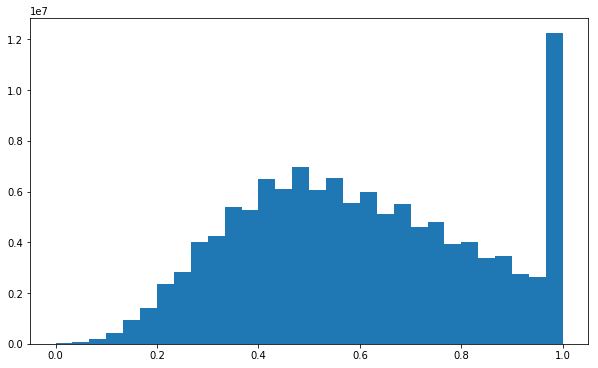

In [8]:
h = plt.hist(x_train.flatten(), bins=30)

In [19]:
np.random.seed(123)

input_img = Input(shape=(128,128,3), name = 'input_img')
x = Conv2D(128, (3, 3), activation='elu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='elu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='elu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='elu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

encoded = Flatten()(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='elu',padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='elu',padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='elu',padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='elu',padding='same')(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

encoder = Model(input_img, encoded)

In [20]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 128, 128, 128)     3584      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 64)        73792     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 32)        18464     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 32)        0         
__________

In [21]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 128, 128, 128)     3584      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 64)        73792     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 32)        18464     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 32)        0         
__________

In [12]:
hfit = autoencoder.fit(x=x_train, y=x_train,
                       epochs=40,
                       batch_size=32, 
                       validation_data=(x_test,x_test), shuffle=True)

Train on 2510 samples, validate on 362 samples
Epoch 1/40
2510/2510 [==============================] - 14s - loss: 0.0393 - val_loss: 0.0338
Epoch 2/40
2510/2510 [==============================] - 11s - loss: 0.0327 - val_loss: 0.0344
Epoch 3/40
2510/2510 [==============================] - 11s - loss: 0.0312 - val_loss: 0.0321
Epoch 4/40
2510/2510 [==============================] - 11s - loss: 0.0304 - val_loss: 0.0312
Epoch 5/40
2510/2510 [==============================] - 11s - loss: 0.0300 - val_loss: 0.0308
Epoch 6/40
2510/2510 [==============================] - 11s - loss: 0.0297 - val_loss: 0.0305
Epoch 7/40
2510/2510 [==============================] - 11s - loss: 0.0293 - val_loss: 0.0302
Epoch 8/40
2510/2510 [==============================] - 11s - loss: 0.0290 - val_loss: 0.0302
Epoch 9/40
2510/2510 [==============================] - 11s - loss: 0.0289 - val_loss: 0.0298
Epoch 10/40
2510/2510 [==============================] - 11s - loss: 0.0286 - val_loss: 0.0296
Epoch 11/40


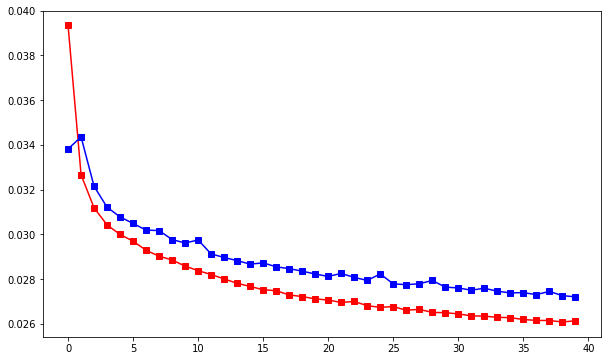

In [13]:
plt.plot(hfit.history["loss"], "r-s")
plt.plot(hfit.history["val_loss"], "b-s")


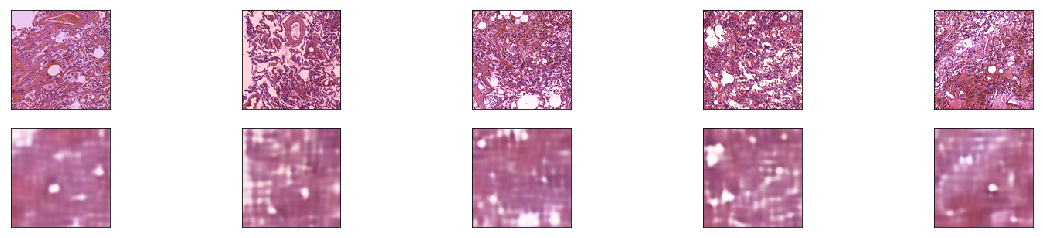

In [14]:
decoded_tiles = autoencoder.predict(x_test)

NUM_TILES = 5  
NROW = 2

plt.figure(figsize=(20, 4))

for i in range(n_images):
    
    # generate top row
    axes = plt.subplot(NROW, NUM_TILES, i + 1)
    
    plt.imshow(x_test[i])
    
    # remove grids
    axes.get_yaxis().set_visible(False)
    axes.get_xaxis().set_visible(False)
    
    # generate bottom row
    axes = plt.subplot(NROW, NUM_TILES, NUM_TILES + i + 1)
    
    plt.imshow(decoded_tiles[i])
    
    # remove grids
    axes.get_yaxis().set_visible(False)
    axes.get_xaxis().set_visible(False)
    

plt.show()

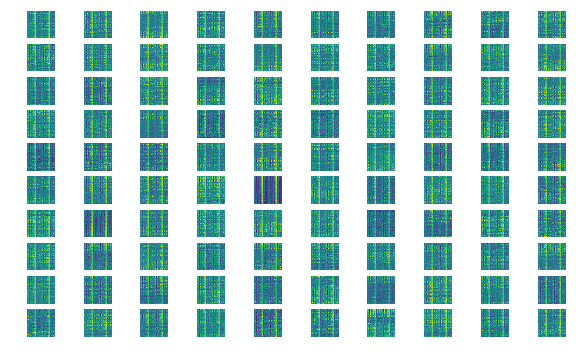

In [15]:
encoded_tiles = encoder.predict(x_test)
plt.figure(figsize=(20, 4))

num_tiles = len(encoded_tiles)

num_row = int(np.sqrt(num_tiles)) if int(np.sqrt(num_tiles)) < 10 else 10
num_col = int(np.sqrt(num_tiles)) if int(np.sqrt(num_tiles)) < 10 else 10

_, axes = plt.subplots(num_row,
                     num_col)

index = 0

for i in range(num_row):
    for j in range(num_col):
        ax[i,j].imshow(encoded_tiles[index].reshape(32,32))
        index += 1
        axes[i,j].axis('off')